In [ ]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("shriyashjagtap/e-commerce-customer-for-behavior-analysis")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/ecommerce_customer_data_custom_ratios.csv")
print(df.head())



Path to dataset files: /root/.cache/kagglehub/datasets/shriyashjagtap/e-commerce-customer-for-behavior-analysis/versions/4
   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        46251  2020-09-08 09:38:32      Electronics             12         3   
1        46251  2022-03-05 12:56:35             Home            468         4   
2        46251  2022-05-23 18:18:01             Home            288         2   
3        46251  2020-11-12 13:13:29         Clothing            196         1   
4        13593  2020-11-27 17:55:11             Home            449         1   

   Total Purchase Amount Payment Method  Customer Age  Returns  \
0                    740    Credit Card            37      0.0   
1                   2739         PayPal            37      0.0   
2                   3196         PayPal            37      0.0   
3                   3509         PayPal            37      0.0   
4                   3452    Credit Card            49      0

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 1. Convert Purchase Date to numerical values (Extract year, month, day)
df["Purchase Date"] = pd.to_datetime(df["Purchase Date"])
df["Purchase_Year"] = df["Purchase Date"].dt.year
df["Purchase_Month"] = df["Purchase Date"].dt.month
df["Purchase_Day"] = df["Purchase Date"].dt.day

# Drop original Purchase Date column
df.drop(columns=["Purchase Date"], inplace=True)



In [ ]:
# 2. One-Hot Encode Product Category & Payment Method
# Apply One-Hot Encoding to categorical features
ohe = OneHotEncoder(drop="first", sparse_output=False)
encoded_features = ohe.fit_transform(df[["Product Category", "Payment Method"]])

# Convert to DataFrame with proper column names
encoded_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(["Product Category", "Payment Method"]))

df.drop(columns=["Product Category", "Payment Method"], inplace=True)
df = pd.concat([df, encoded_df], axis=1)

gender_encoder = LabelEncoder()
df["Gender"] = gender_encoder.fit_transform(df["Gender"])

df.drop(columns=["Customer Name"], inplace=True)  # Drop because it's not useful

print("All categorical features have been converted into numerical values.")
print(df.head())


All categorical features have been converted into numerical values.
   Customer ID  Product Price  Quantity  Total Purchase Amount  Customer Age  \
0        46251             12         3                    740            37   
1        46251            468         4                   2739            37   
2        46251            288         2                   3196            37   
3        46251            196         1                   3509            37   
4        13593            449         1                   3452            49   

   Returns  Age  Gender  Churn  Purchase_Year  Purchase_Month  Purchase_Day  \
0      0.0   37       1      0           2020               9             8   
1      0.0   37       1      0           2022               3             5   
2      0.0   37       1      0           2022               5            23   
3      0.0   37       1      0           2020              11            12   
4      0.0   49       0      1           2020           

In [ ]:
df.drop(columns = ["Age"], inplace = True)

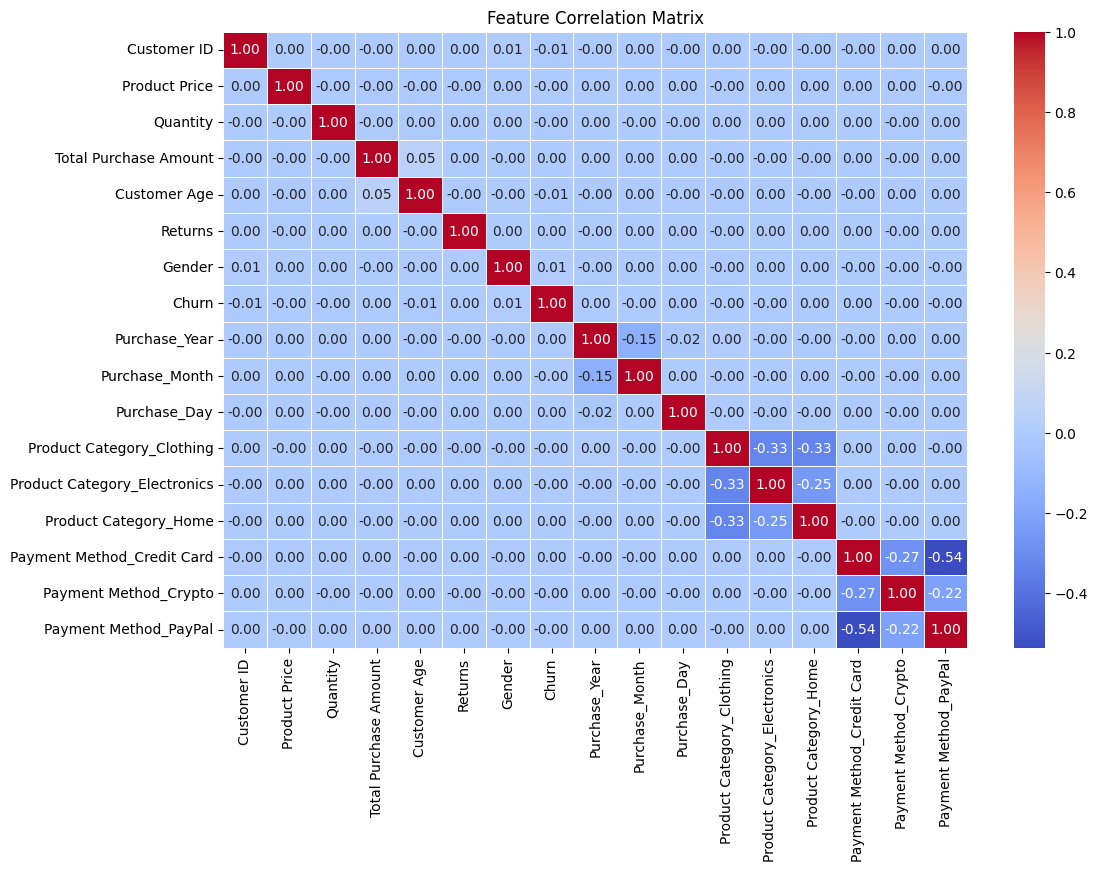

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

#ideally i would have liked to have greater values in the churn column
#not that useful

In [ ]:
# Sort features by absolute correlation with the target variable
target_corr = corr_matrix["Churn"].abs().sort_values(ascending=False)
print("Feature Correlation with Churn:\n", target_corr)


Feature Correlation with Churn:
 Churn                           1.000000
Gender                          0.008182
Customer Age                    0.006015
Age                             0.006015
Customer ID                     0.005398
Purchase_Year                   0.003465
Purchase_Day                    0.003399
Product Category_Home           0.003155
Quantity                        0.002674
Returns                         0.001863
Product Price                   0.001666
Product Category_Clothing       0.001629
Payment Method_PayPal           0.001020
Product Category_Electronics    0.000817
Total Purchase Amount           0.000770
Payment Method_Credit Card      0.000764
Payment Method_Crypto           0.000607
Purchase_Month                  0.000573
Name: Churn, dtype: float64


In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Define input features (X) and target variable (y)
X = df.drop(columns=["Churn"])
y = df["Churn"]

X = X.fillna(0)

# Compute Mutual Information scores
mi_scores = mutual_info_classif(X, y, discrete_features="auto")

# Convert to Pandas Series for easy sorting
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Feature Importance (Mutual Information):\n", mi_scores_series)


#Categories with higher mutual information are to be preferred
#selecting only the features which have mutual information score greater than 0.01


Feature Importance (Mutual Information):
 Customer ID                     0.437823
Gender                          0.028226
Payment Method_Credit Card      0.018598
Returns                         0.017392
Product Category_Clothing       0.010882
Payment Method_PayPal           0.010251
Purchase_Year                   0.008495
Quantity                        0.006781
Product Category_Home           0.004234
Product Category_Electronics    0.003971
Purchase_Month                  0.002584
Customer Age                    0.001500
Payment Method_Crypto           0.001314
Product Price                   0.000638
Total Purchase Amount           0.000000
Purchase_Day                    0.000000
dtype: float64


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("Variance Inflation Factor (VIF):\n", vif_data.sort_values(by="VIF", ascending=True))

#yeah, so here we can remove the features that have a score greater than 5



Variance Inflation Factor (VIF):
                          Feature        VIF
14         Payment Method_Crypto   1.496796
12         Product Category_Home   1.665567
11  Product Category_Electronics   1.669986
5                        Returns   1.675361
6                         Gender   1.991230
10     Product Category_Clothing   2.001998
15         Payment Method_PayPal   2.499982
13    Payment Method_Credit Card   3.014090
0                    Customer ID   4.003655
9                   Purchase_Day   4.161284
1                  Product Price   4.236086
8                 Purchase_Month   4.401447
3          Total Purchase Amount   4.580046
2                       Quantity   5.493902
4                   Customer Age   9.219416
7                  Purchase_Year  37.524652


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Train a simple Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importance scores
feature_importances = model.feature_importances_

# Convert to Pandas Series for sorting
feature_importance_series = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)

print("Feature Importance (Random Forest):\n", feature_importance_series)


Feature Importance (Random Forest):
 Customer ID                     0.174982
Total Purchase Amount           0.167669
Product Price                   0.158602
Customer Age                    0.115235
Purchase_Day                    0.106969
Purchase_Month                  0.078802
Quantity                        0.047777
Purchase_Year                   0.039080
Returns                         0.019333
Payment Method_Credit Card      0.015866
Product Category_Clothing       0.014700
Payment Method_PayPal           0.014328
Product Category_Electronics    0.013093
Product Category_Home           0.012172
Gender                          0.011881
Payment Method_Crypto           0.009510
dtype: float64


In [ ]:
#finally the features i would like to select are
#Returns
#quantity
#customer Age
#product category
#purchase Method
#Gender